In [7]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [25]:
df = pd.read_csv("../data/PEACH/hr_neighbors.csv", usecols=range(5))

print "total number of lines =", len(df)

df_clean = df[(df.rssi<0)]

lines_removed = len(df) - len(df_clean)
df_clean.loc[:,"date"] = pd.to_datetime(df_clean.time, unit='s')

print "number of lines removed = ", lines_removed, "(", float(lines_removed)*100/len(df), "% )"
print "Data from ", df_clean.date[0], "to", df_clean.date[len(df_clean.date)-1]

df_clean.head()

total number of lines = 34990
number of lines removed =  61 ( 0.174335524436 % )
Data from  2016-06-29 15:41:38 to 2016-07-05 05:07:28


,time,mac,neighborMac,neighborFlag,rssi,date
0,1467214898,00-17-0d-00-00-30-60-ef,00-17-0d-00-00-60-05-78,0,-84,2016-06-29 15:41:38
1,1467214898,00-17-0d-00-00-30-60-ef,00-17-0d-00-00-60-02-4b,0,-85,2016-06-29 15:41:38
2,1467214898,00-17-0d-00-00-30-60-ef,00-17-0d-00-00-3f-f8-20,0,-60,2016-06-29 15:41:38
3,1467214898,00-17-0d-00-00-30-60-ef,00-17-0d-00-00-60-05-ab,0,-84,2016-06-29 15:41:38
4,1467214898,00-17-0d-00-00-30-60-ef,00-17-0d-00-00-60-05-5f,0,-76,2016-06-29 15:41:38


## Link Asymmetry

In [38]:
# removing non DC9008 boards
excluded_macs = ["00-17-0d-00-00-b0-00-cc", "00-17-0d-00-00-b0-00-aa", "00-17-0d-00-00-b0-00-87",
                 "00-17-0d-00-00-30-60-ef", "00-17-0d-00-00-58-32-36"
                 ]
df_reduced = df_clean[(~df_clean.mac.isin(excluded_macs)) & (~df_clean.neighborMac.isin(excluded_macs))]


def get_hash(A, B):
    return ''.join(sorted([A, B]))


def check_hash(A, B, hash):
    if ''.join([A, B]) == hash:
        return True
    else:
        return False

df_reduced["hash"] = df_reduced.apply(lambda row: (get_hash(row["mac"], row["neighborMac"])), axis=1)

df_indexed = df_reduced.set_index(df_reduced["date"])

hash_grouped = df_indexed.groupby(["hash"])

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [60]:
diff_list = []

# for each link
for hash, group in hash_grouped:
    AtoB = []
    BtoA = []
    
    # resample and separate A->B and B->A links
    for m, gr in group.groupby(group["mac"]):
        rssi_resampled = gr.rssi.resample('1h').mean()
        
        if check_hash(gr["mac"][0], gr["neighborMac"][0], hash):
            AtoB = rssi_resampled
        else:
            BtoA = rssi_resampled
    
    # compute RSSI difference for each time bin
    rssi_diff = pd.Series(AtoB).subtract(pd.Series(BtoA)).dropna()
    
    # only select link with important traffic
    if len(rssi_diff) > 1000: 
        diff_list.append([str(gr["mac"][0]), str(gr["neighborMac"][0]), len(rssi_diff), abs(rssi_diff.mean()), rssi_diff.std(), rssi_diff])

print "Total number of nodes:", len(df_indexed.groupby(["mac"]))
print "Total number of active links:", len(diff_list)
print "Total number of HR_NEIGHBORS:", df_clean.count()[1]
print "Active links between ", df_clean.date[0], "and", df_clean.date[len(df_clean.date)-1]

Total number of nodes: 14
Total number of active links: 7
Total number of HR_NEIGHBORS: 506235
Active links between  2016-06-29 15:41:38 and 2016-09-23 02:51:32


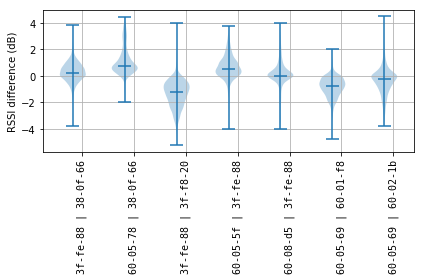

In [66]:
df_final = pd.DataFrame(diff_list, columns=["mac_1", "mac_2", "count", "mean", "std", "values"])
df_final.set_index(["mac_1", "mac_2"], inplace=True)

ind = np.arange(len(df_final.index))
bar_width = 0.35

plt.violinplot(df_final["values"], ind,
    showmeans=False, showmedians=True
    )
plt.xticks(ind + bar_width / 2, [str(i[0])[-8:]+ " | " +str(i[1])[-8:] for i in df_final.index],
           rotation=90, fontname="monospace")

plt.ylabel('RSSI difference (dB)')
plt.legend()

plt.grid(True)
plt.tight_layout() # make sure xlabels are not cut off

plt.savefig("../figures/asymmetry_peach.eps", format='eps')
plt.show()